# Models to predict Coronavirus spreading and infection of COVID-19 in different countries

Tomáš Kulhánek<sup>1,2</sup>, Jiří Kofránek<sup>1,2</sup>

<sup>1</sup>Department of Biocybernetics and Computer Aided Learning, Institute of Pathological Physiology, First Faculty of Medicine, Charles University in Prague <sup>2</sup>Creative Connections,s.r.o. 

This notebook is not official source of information, but use public data to compare several models to follow and predict spreading of Coronavirus and infection of COVID-19 in the world. Data are taken from public resources, see references bellow. The computation is scripted using Python and libaries supporting data science. This notebook is still in development and is being updated in daily/weekly basis for few weeks(March 2020). If you find any issue, report it or use PR.

This notebook is interactive, with text cells and code cells. It's possible to move using keybord arrows. In order to execute the code, you may need to do that in the order from top to bottom - Press `Shift-Enter`. Content of the cell is editable, thus you may change the content and rerun them by pressing `Shift-Enter`.

In [1]:
# First we import related python libs used further
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
%matplotlib inline

Now we define routines to obtain data from public databases. See References bellow

In [2]:
#cache data
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dfi = pd.read_csv(url)
#data from Italian national agency, seems to be updated in daily basis
def getdatafromItaly():
    global dfi
    df = dfi
    df = df.loc[:,['data','totale_casi']]
    FMT = '%Y-%m-%d %H:%M:%S'
    date = df['data']
    df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )
    return df

In [3]:
#cache data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
dfw = pd.read_csv(url)
def getdatafromWHO(country,addlastdaynum=0):
    global dfw
    df3 = dfw
    #select country,region
    dfcz = df3.loc[df3['Country/Region']==country,:]
    #select only data relevant of coronavirus COVID-19, strip country name, location,... 
    dfcz2 = dfcz.iloc[:,4:]
    #strip columns where infected is 0
    dfcz21 = dfcz2.loc[:, (dfcz2 != 0).any(axis=0)]
    dfcz22 = dfcz21.rename(index={dfcz21.first_valid_index():"infected"},errors="raise")
    #transpose
    dfcz3 = dfcz22.transpose()
    #calculate number of days from 1.1.2020 based on date in first column
    d = (datetime.strptime(dfcz21.columns[0], "%m/%d/%y")-datetime(2020,1,1)).days
    #insert just day numbers 
    dfcz3.insert(0,'days',range(d,int(d+len(dfcz3.index))))
    #optionally append one number with most updated data - 13.3. number 113
    if (addlastdaynum>0):
        dfcz33 = dfcz3.append({"days":d+len(dfcz3.index),"infected":addlastdaynum},ignore_index=True)
        return dfcz33
    return dfcz3
    #print(dfcz33,df2)
    

In [4]:
def getdatafromCzechia():
    # TODO CSV resource not found yet, manually updated every day, https://onemocneni-aktualne.mzcr.cz/covid-19
    crdata=[['days','infected'],[61,3],[62,3],[63,5],[64,5],[65,8],[66,19],[67,26],[68,32],[69,38],[70,63],
            [71,94],[72,116],[73,141],[74,189],[75,298],[76,383],[77,436],[78,560]]
    df2 = pd.DataFrame(crdata[1:],columns=crdata[0])
    return df2

## Logistic model
Logistic model may fit the spreading of some infection in population. See https://en.wikipedia.org/wiki/Logistic_regression

$$ f(x,a,b,c)= \frac{c}{1+e^\frac{-(x-b)}{a} } $$

* $x$ time
* $a$ speed of infection
* $b$ critical point, day when most infected people was recorded
* $c$ total number of infected people

In [5]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



# Exponencial model
Exponencial model may better fit the uncontrollable spreading of infection in the beginning, when no action was taken.

$$ f(x,a,b,c)= a.e^{b(x-c)} $$

In [6]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

 # Model fit to data
 The models have parameters, these parameters might be estimated thus the real data fits the model. We use method of  `curve_fit` from scipy library `scipy`. 

In [7]:
def getxy(dfcz33):
    x = list(dfcz33.iloc[:,0])
    y = list(dfcz33.iloc[:,1])
    return (x,y)

def fitlogisticmodel(x,y):
    #fit data to logistic model
    fit=[[4,75,100000]]
    try:
        #fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],method='lm')#,bounds=([0.5,30,15][10,120,10e+7]))
        fit = curve_fit(logistic_model,x,y,p0=[2,70,20000],method='lm',maxfev=5000)#,bounds=([0.5,30,15][10,120,10e+7]))
    except:
        print('fit not found, attemp 0');
        for i in range(1,5):
            try:
                fit = curve_fit(logistic_model,x,y,p0=[i,70,i*1000**(i/3)],bounds=([0.5,60,15][10,120,1e+7]),maxfev=5000)
                break;
            except:
                print('fit not found, attemp ',i);
    #a,b,c parameters of model, c total infected, b reversal day number of daily infected starts decrease
    (a,b,c)=(fit[0][0],fit[0][1],fit[0][2])
    #lastday when somebody is infected
    lastday = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    #errors - uncertainty
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    print('Parameters of logistic model fit a:',a,' b:',b,' c:',c,' errors of c:',errors[2])
    return (fit,lastday,errors)

def fitlogisticmodel_b(x,y,fixb):
    #fit data to logistic model with already estimated parameter B 
    fit = curve_fit(logistic_model,x,y,p0=[2,fixb,20000],bounds=[[1,fixb,150],[10,fixb+1,10e+6]])
    
    #a,b,c parameters of model, c total infected, b reversal day number of daily infected starts decrease
    (a,b,c)=(fit[0][0],fit[0][1],fit[0][2])
    #lastday when somebody is infected
    lastday = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    #errors - uncertainty
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    print('Parameters of logistic model fit a:',a,' b:',b,' c:',c,' errors of c:',errors[2])
    return (fit,lastday,errors)

In [8]:
def fitexponentialmodel(x,y):
    #fit data to exponential model
    exp_fit = curve_fit(exponential_model,x,y,p0=[0.02,0.1,2.8])
    return exp_fit


# Vizualisation of results and prediction of models based on real data

Now we will define routines to visualize real data and model with parameters, we may extrapolate models to predict future. 

In [9]:
# renders one basic plotchart with logistic, exponential model and real data, 
# for logistic model it shows total predicted infected people
def plotchart(x,y,lastday,fit,exp_fit,errors):
    pred_x = list(range(max(x),lastday))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
    # line with predicted total infected
    plt.axhline(y=fit[0][2], color='b', linestyle='dotted')
    plt.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    # uncertainty interval +- errors
    plt.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,fit[0][2]*1.1))
    plt.show()
    
# this shows - compares two logistic models in a graph - e.g. one with fixed estimated critical point 
# lastday2,fit2,exp_fit2 - is denoted as 'Realistic model'
def plotcharts(x,y,lastday,fit,exp_fit,errors,lastday2,fit2,errors2):
    pred_x = list(range(max(x),lastday))
    pred_x2 = list(range(max(x),lastday2))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=12)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Optimistic L. model" )
    plt.plot(x+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Realistic L. model b=85" )
    # Predicted exponential curve
    plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    plt.axhline(y=fit[0][2], color='g', linestyle='dotted')
    plt.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    plt.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    plt.text(lastday2-2,fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    plt.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1))    
    plt.show()

# this show two charts - one as above, the second with y in logarithmic scale    
def plotcharts_norm_vs_log(x,y,lastday,fit,exp_fit,errors,lastday2,fit2,errors2):
    pred_x = list(range(max(x),lastday))
    pred_x2 = list(range(max(x),lastday2))
    plt.rcParams['figure.figsize'] = [14, 7]
    plt.rc('font', size=10)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Real data
    ax1.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    ax1.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Optimistic logistic model b="+str(int(fit[0][1])))
    ax1.plot(x+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Realistic logistic model b="+str(int(fit2[0][1]))) 
    # Predicted exponential curve
    ax1.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    ax1.axhline(y=fit[0][2], color='g', linestyle='dotted')
    ax1.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    ax1.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    ax1.text(lastday2-2,fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    ax1.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    ax1.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    ax1.legend()
    ax1.set(xlabel="Days since 1 January 2020",ylabel="Total number of infected people",
            ylim=(min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1))    

    # Real data
    ax2.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    ax2.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Optimistic logistic model b="+str(int(fit[0][1])))
    ax2.plot(x+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x+pred_x2], label="Realistic logistic model b="+str(int(fit2[0][1])))
    # Predicted exponential curve
    ax2.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" ) 
    # line with predicted total infected
    ax2.axhline(y=fit[0][2], color='g', linestyle='dotted')
    ax2.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    ax2.axhline(y=fit2[0][2], color='b', linestyle='dotted')
    ax2.text(lastday2-2,fit2[0][2]*1.02,int(fit2[0][2]))
    # uncertainty interval +- errors
    ax2.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]-errors2[2], color='lightblue', linestyle='dotted')
    ax2.axhline(y=fit[0][2]+errors2[2], color='lightblue', linestyle='dotted')
    ax2.legend()
    ax2.set(xlabel="Days since 1 January 2020",ylabel="Total number of infected people, log scale",
            ylim=(min(y)*0.9,max([fit[0][2],fit2[0][2]])*1.1),    
            yscale="log")
    
    plt.show()
    

# Data analysis 

We can define function with a sequence to obtain raw data, do fitting and visualize prediction

In [10]:

def analyze_data(df,estb=0):
    (x,y) = getxy(df)
    #try to fit all parameters a,b,c    
    (fit,lastday,errors) = fitlogisticmodel(x,y)
    #try to fit parameters a,c, 
    #estimate b (critical point) as e.g. 7-14 days after 
    #quarantine and other actions were introduced in population
    fit_exp = fitexponentialmodel(x,y)
    date_lastday=datetime(2020,1,1) + timedelta(days=lastday)    
    if estb>0:
        (fit2,lastday2,errors2) = fitlogisticmodel_b(x,y,estb)
        plotcharts_norm_vs_log(x,y,lastday,fit,fit_exp,errors,lastday2,fit2,errors2)
    else:
        plotchart(x,y,lastday,fit,fit_exp,errors)
    return (date_lastday,fit,errors)
    
def analyze_for_country(country,addlastnum=0,estb=0):
    # get data from WHO
    df = getdatafromWHO(country,addlastnum)
    (date_lastday,fit,errors) = analyze_data(df,estb)
    #print('Model of COVID-19 infection in',country,'based on real data predicts last infected person at ',date_lastday.strftime('%d.%m.%Y'),' with total infected people ',int(fit[0][2]),'(+-', int(errors[2]),'). ')

def analyze_czechia(estb=0):    
    df = getdatafromCzechia()
    (date_lastday,fit,errors) = analyze_data(df,estb)
    #print('Model of COVID-19 infection in Czechia based on real data predicts last infected person at ',date_lastday.strftime('%d.%m.%Y'),' with total infected people ',int(fit[0][2]),'(+-', int(errors[2]),'). ')


# Model prediction for Czechia

Data are available from [3] and [2]. Comparing model prediction for both data.

Parameters of logistic model fit a: 2.8013913230275067  b: 76.66388666367178  c: 878.7786632395822  errors of c: 112.16474044923305
Parameters of logistic model fit a: 3.7464343309508568  b: 85.00000000000001  c: 4581.979982350491  errors of c: 7980.395826721318


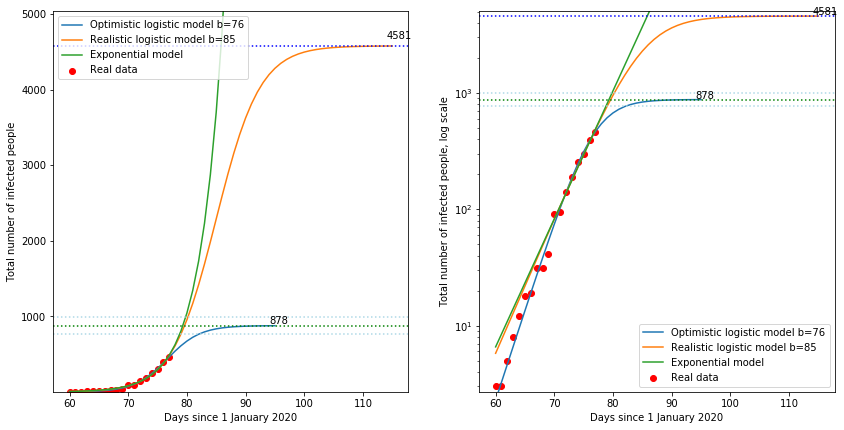

In [11]:
analyze_for_country('Czechia',estb=85) 


Parameters of logistic model fit a: 2.789910398047626  b: 78.10643140855699  c: 1133.361587546707  errors of c: 210.98108246616218
Parameters of logistic model fit a: 3.5768122746054587  b: 85.0000000000053  c: 4637.133490429653  errors of c: 6928.642987527475


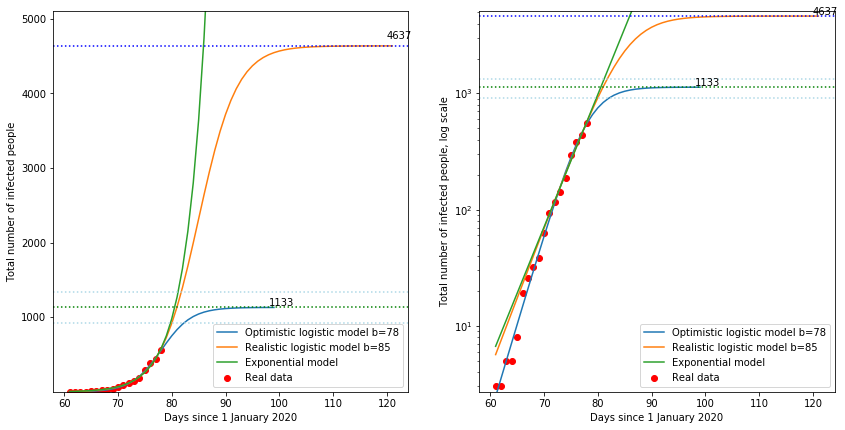

In [12]:
analyze_czechia(estb=85)

## Summary for Czechia
Model fitting is sensitive on real data [2],[3]. The prediction differs, however the order for realistic model seems to be same. The trajectories are still exponential and it seems that we're not behind critical point 'b'. Therefore we added manually estimated critical point b as 12 days after drastic arrangments were introduced by governemnt 13.3.2020. Which is day 85. (Incubation period of COVID-19 seems to be betwee 7 and 14 days)

We will see the future.

# Model and prediction for South Korea

Parameters of logistic model fit a: 2.9815466721711696  b: 60.683214902422606  c: 8213.510967645434  errors of c: 32.33190192829713


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


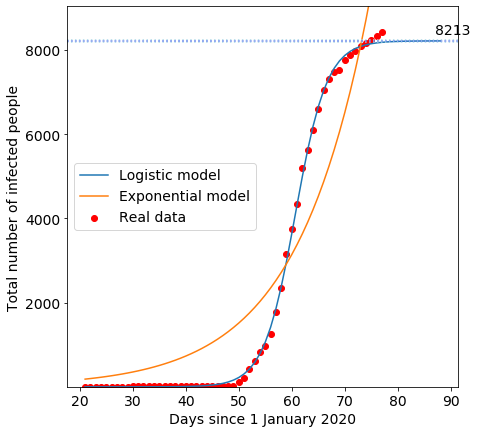

In [13]:
analyze_for_country('Korea, South')

## Summary for South Korea

From real data, South Korea seems to reach critical point at day around 60 (1/3/2020). Prediction of the logistic model fits and do not differ from daily updates.

* 13/3/2020 Predicted total 7982 (+- 38 ). 
* 16/3/2020 Predicted total 8097 (+-32). 
* 17/3/2020 Predicted total 8133 (+-31).


# Model and prediction for Italy

Data are available from WHO and from italian sources[1] [3]. 

Parameters of logistic model fit a: 4.53007794780924  b: 77.29931697256873  c: 74036.2874133833  errors of c: 6250.249414235963
Parameters of logistic model fit a: 5.114601952389606  b: 81.00000000000001  c: 116528.6052546041  errors of c: 21839.428628725964


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


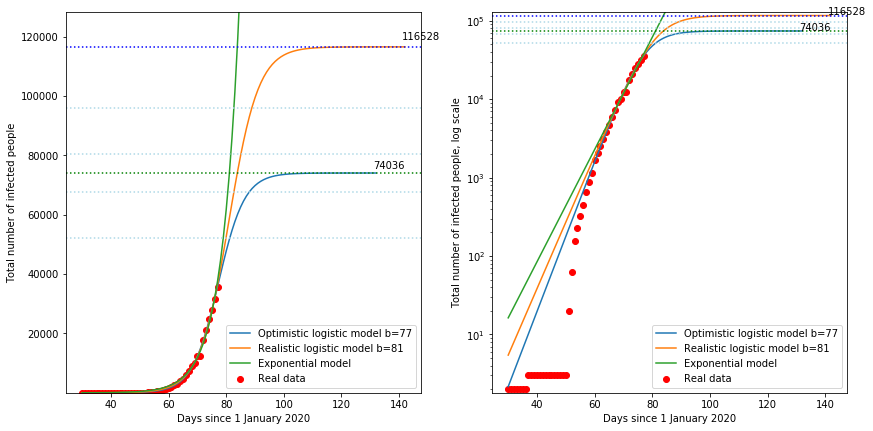

In [14]:
analyze_for_country('Italy',estb=81)

Parameters of logistic model fit a: 4.446493957635346  b: 76.51935960634685  c: 67488.04960834382  errors of c: 2713.486429581591
Parameters of logistic model fit a: 5.198328570403066  b: 81.00000000000003  c: 115492.16094204895  errors of c: 23017.96551352645


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


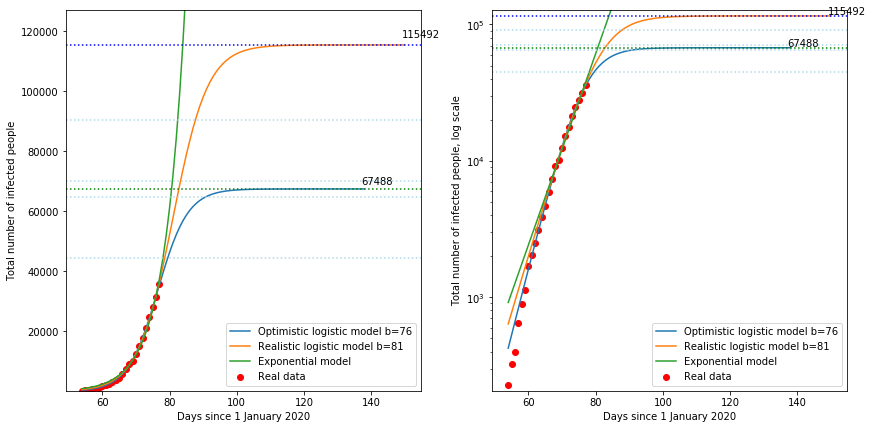

(datetime.datetime(2020, 5, 19, 0, 0),
 (array([4.44649396e+00, 7.65193596e+01, 6.74880496e+04]),
  array([[6.01761145e-03, 2.47543790e-02, 1.93953961e+02],
         [2.47543790e-02, 1.14463628e-01, 9.14007014e+02],
         [1.93953961e+02, 9.14007014e+02, 7.36300860e+06]])),
 [0.07757326506174697, 0.3383247376511627, 2713.486429581591])

In [15]:
df3=getdatafromItaly()
analyze_data(df3,estb=81)

## Summary for Italy 
Models are sensitive on real data,[1] a [3], it slightly differs, however has same trends
* 13/3/2020 predicts 42393 (+-7887) vs 19293 (+-1111). 
* 16/3/2020 predicts 73519 (+-9427) vs 134252 (+-65720). 

We add estimated `b` as 12 days after drastic arrangements were taken in Italy (9/3/2020). b=81 (21/3/2020).
* 16/3/2020 Realistic model predicts predicts 128639 (+-41596).
* 17/3/2020 Realistic model predicts 123533 (+-34187).

# Other countries

In [16]:
# do analysis for your country, check correct country/region name in data source [3]
print(dfw[['Country/Region']])

     Country/Region
0          Thailand
1             Japan
2         Singapore
3             Nepal
4          Malaysia
..              ...
457     Netherlands
458          Zambia
459        Djibouti
460     Gambia, The
461  United Kingdom

[462 rows x 1 columns]


Parameters of logistic model fit a: 3.819313895798361  b: 90.66276246000723  c: 449819.7609788539  errors of c: 1067382.3617449976
Parameters of logistic model fit a: 3.8193130292656634  b: 90.66268466033718  c: 449811.0833688506  errors of c: 1067360.4430266623


/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


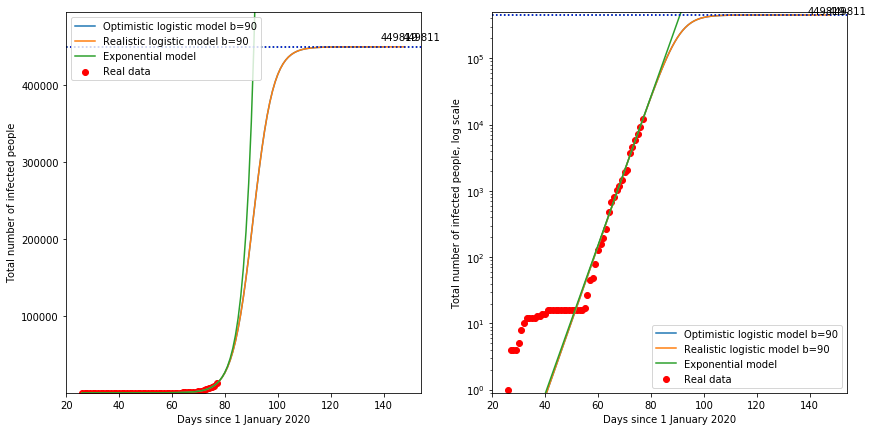

In [17]:
# replace country name 
analyze_for_country('Germany',estb=90)

# References
* [1] Gianluca Malato, Covid-19 infection in Italy. Mathematical models and predictions. Data from Italy https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* [2] Data from Czechia https://onemocneni-aktualne.mzcr.cz/covid-19
* [3] World data updated by Johns Hopkins University Center for Systems Science and Engineering https://github.com/CSSEGISandData/COVID-19